In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())


text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64


In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(train_dataset)
print(test_dataset)

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>
<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>


In [7]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])


texts:  [b'Loved it! What\'s not to like?--you got your suburbia, you got your zombies, you got your family issues, you got your social dilemmas, you got yourself one Fine Retro-1950\'s-style Flesh Eating Under Class Held At Bay By An Uneasy Worried About Whether They\'re The Next Meal Upper Crust. You couldn\'t ask for more.<br /><br />Cast is superb. Carrie Ann Moss is absolute perfection as a debutante social climbing housewife. She\'s both wanton, and criminally conspiratorial. Every fellow\'s dream. K\'sun is really great as the son just trying to be as normal as possible in this nightmare existence, and somehow succeeding. He\'s a genuine screen presence. Very photogenic, and natural. Without naming them all, the rest of the cast is wonderful. Henry Czerny plays a suspicious policeman with honed instincts and little squeamishness as if it\'s his everyday persona. Billy Connolly is delightful as Fido. A fine actor: I wish that he had played the title role in "Braveheart," with Gib

In [8]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))


In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example


array([[434,   9, 697, ...,   0,   0,   0],
       [  6,  28,   1, ...,   0,   0,   0],
       [ 11,  20,   7, ...,   0,   0,   0]])

In [11]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()


Original:  b'Loved it! What\'s not to like?--you got your suburbia, you got your zombies, you got your family issues, you got your social dilemmas, you got yourself one Fine Retro-1950\'s-style Flesh Eating Under Class Held At Bay By An Uneasy Worried About Whether They\'re The Next Meal Upper Crust. You couldn\'t ask for more.<br /><br />Cast is superb. Carrie Ann Moss is absolute perfection as a debutante social climbing housewife. She\'s both wanton, and criminally conspiratorial. Every fellow\'s dream. K\'sun is really great as the son just trying to be as normal as possible in this nightmare existence, and somehow succeeding. He\'s a genuine screen presence. Very photogenic, and natural. Without naming them all, the rest of the cast is wonderful. Henry Czerny plays a suspicious policeman with honed instincts and little squeamishness as if it\'s his everyday persona. Billy Connolly is delightful as Fido. A fine actor: I wish that he had played the title role in "Braveheart," with G

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [13]:
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


In [14]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])


[0.0102379]


In [15]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])


[0.0102379]


In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)


Epoch 1/10
391/391 [==============================] - 170s 427ms/step - loss: 0.6805 - accuracy: 0.5244 - val_loss: 0.5009 - val_accuracy: 0.7781
Epoch 2/10
391/391 [==============================] - 163s 417ms/step - loss: 0.4423 - accuracy: 0.7985 - val_loss: 0.3862 - val_accuracy: 0.8422
Epoch 3/10
391/391 [==============================] - 164s 419ms/step - loss: 0.3513 - accuracy: 0.8452 - val_loss: 0.3362 - val_accuracy: 0.8578
Epoch 4/10
391/391 [==============================] - 162s 414ms/step - loss: 0.3219 - accuracy: 0.8575 - val_loss: 0.3348 - val_accuracy: 0.8599
Epoch 5/10
391/391 [==============================] - 164s 418ms/step - loss: 0.3171 - accuracy: 0.8611 - val_loss: 0.3275 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 163s 418ms/step - loss: 0.3112 - accuracy: 0.8656 - val_loss: 0.3234 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 165s 421ms/step - loss: 0.3063 - accuracy: 0.8669 - val_loss: 0.3309 -

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))


391/391 [==============================] - 47s 120ms/step - loss: 0.3180 - accuracy: 0.8616
Test Loss: 0.3180348575115204
Test Accuracy: 0.8615599870681763


(0.0, 0.654562146961689)

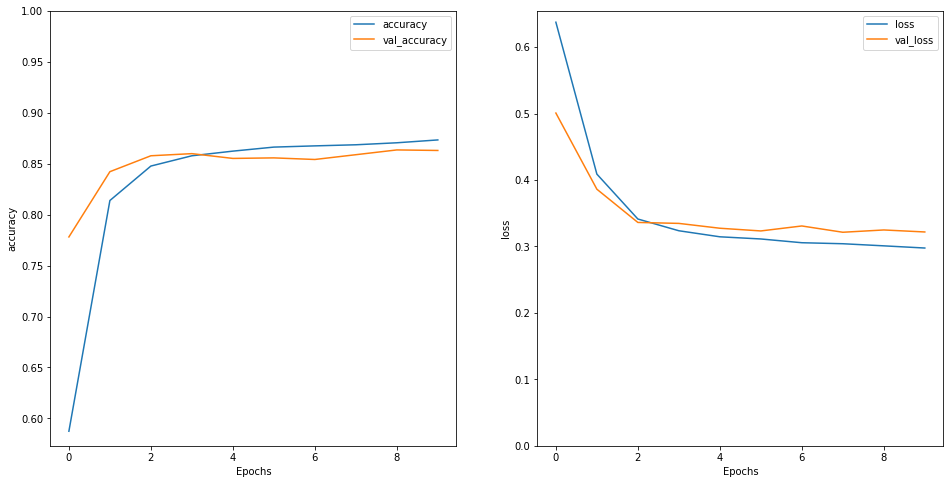

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)


In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))


In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/10
391/391 [==============================] - 325s 812ms/step - loss: 0.6714 - accuracy: 0.5308 - val_loss: 0.4022 - val_accuracy: 0.8302
Epoch 2/10
391/391 [==============================] - 313s 801ms/step - loss: 0.3816 - accuracy: 0.8331 - val_loss: 0.3492 - val_accuracy: 0.8354
Epoch 3/10
391/391 [==============================] - 313s 801ms/step - loss: 0.3329 - accuracy: 0.8577 - val_loss: 0.3535 - val_accuracy: 0.8240
Epoch 4/10
391/391 [==============================] - 313s 800ms/step - loss: 0.3234 - accuracy: 0.8623 - val_loss: 0.3406 - val_accuracy: 0.8323
Epoch 5/10
391/391 [==============================] - 318s 814ms/step - loss: 0.3116 - accuracy: 0.8648 - val_loss: 0.3730 - val_accuracy: 0.8042
Epoch 6/10
391/391 [==============================] - 312s 798ms/step - loss: 0.3124 - accuracy: 0.8650 - val_loss: 0.3288 - val_accuracy: 0.8458
Epoch 7/10
391/391 [==============================] - 317s 811ms/step - loss: 0.3028 - accuracy: 0.8703 - val_loss: 0.3184 -

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)


In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
